## 1. Import Library yang Dibutuhkan
**Tujuan**: Mengimpor pustaka yang diperlukan untuk pemrosesan data, visualisasi, preprocessing teks, dan pembangunan model deep learning dengan TensorFlow/Keras.

In [4]:
# Import library yang dibutuhkan
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import io
from sklearn.utils import shuffle

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YogaNzm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\YogaNzm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\YogaNzm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Memuat Dataset
**Tujuan**: Membaca file `isear.csv`, `train.txt`, `val.txt`, dan `test.txt` lalu menyusunnya ke dalam DataFrame. Ditampilkan juga informasi bentuk dan contoh isi dataset.


In [5]:
# Fungsi untuk membaca dataset
def read_file(file_path, delimiter=';'):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    texts = []
    labels = []
    
    for line in lines:
        if delimiter in line:
            parts = line.strip().split(delimiter)
            if len(parts) >= 2:
                texts.append(parts[0].strip())
                labels.append(parts[1].strip())
    
    return texts, labels

# Load dataset isear.csv
def load_isear_data(file_path):
    df = pd.read_csv(file_path)
    # Mengambil 2 kolom pertama
    if len(df.columns) >= 2:
        df = df.iloc[:, :2]
        df.columns = ['emotion', 'text']
        # Pastikan tidak ada nilai yang hilang
        df = df.dropna()
        return df
    else:
        print("Error: File CSV tidak memiliki cukup kolom")
        return None

# Load dataset
try:
    # Load ISEAR dataset
    isear_df = load_isear_data('dataset/isear.csv')
    
    # Load dataset tambahan
    train_texts, train_labels = read_file('dataset/train.txt')
    val_texts, val_labels = read_file('dataset/val.txt')
    test_texts, test_labels = read_file('dataset/test.txt')
    
    # Buat DataFrame untuk dataset tambahan
    train_df = pd.DataFrame({'text': train_texts, 'emotion': train_labels})
    val_df = pd.DataFrame({'text': val_texts, 'emotion': val_labels})
    test_df = pd.DataFrame({'text': test_texts, 'emotion': test_labels})
    
    # Tampilkan informasi dataset
    print("ISEAR Dataset Shape:", isear_df.shape if isear_df is not None else "Not loaded")
    print("Train Dataset Shape:", train_df.shape)
    print("Validation Dataset Shape:", val_df.shape)
    print("Test Dataset Shape:", test_df.shape)
    
    # Tampilkan sample dari setiap dataset
    print("\nISEAR Sample:")
    if isear_df is not None:
        print(isear_df.head())
    
    print("\nTrain Sample:")
    print(train_df.head())
    
    print("\nValidation Sample:")
    print(val_df.head())
    
    print("\nTest Sample:")
    print(test_df.head())
    
except Exception as e:
    print(f"Error loading datasets: {e}")

ISEAR Dataset Shape: (7651, 2)
Train Dataset Shape: (16000, 2)
Validation Dataset Shape: (2000, 2)
Test Dataset Shape: (2000, 2)

ISEAR Sample:
   emotion                                               text
0     fear  Every time I imagine that someone I love or I ...
1    anger  When I had been obviously unjustly treated and...
2  sadness  When I think about the short time that we live...
3  disgust  At a gathering I found myself involuntarily si...
4    shame  When I realized that I was directing the feeli...

Train Sample:
                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

Validation Sample:
                                                text  emotion
0  im feeling q

## 3. Penggabungan Dataset dan Eksplorasi Data
**Tujuan**: Menggabungkan semua dataset, menampilkan distribusi label emosi, serta menganalisis statistik panjang teks sebelum preprocessing.


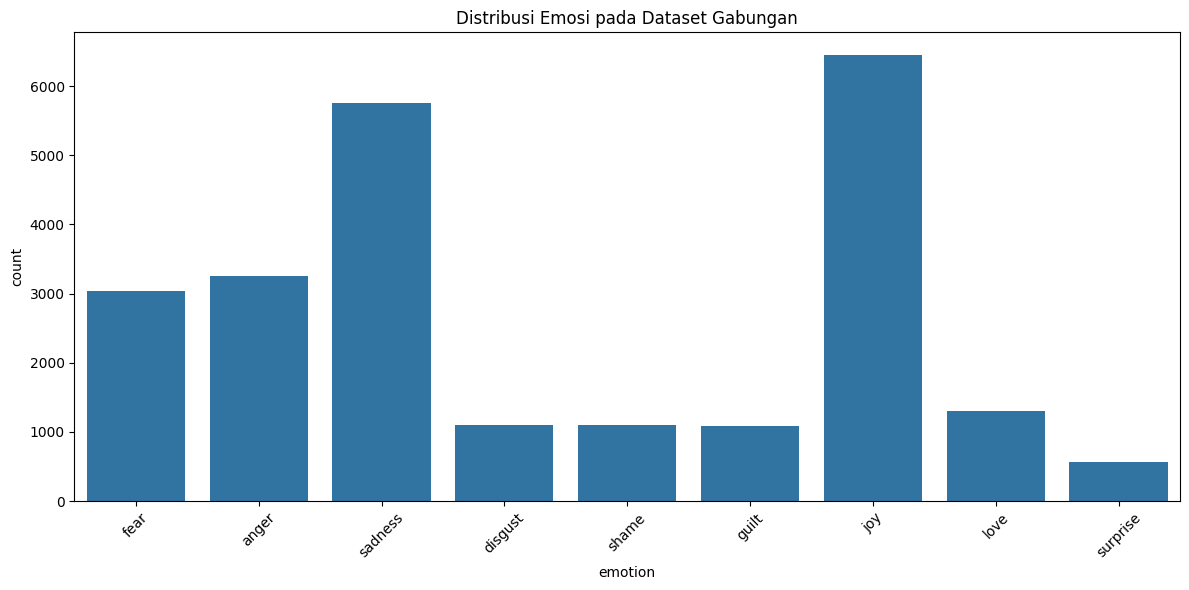

Jumlah data per emosi:
emotion
joy         6453
sadness     5760
anger       3253
fear        3030
love        1304
disgust     1094
shame       1094
guilt       1091
surprise     572
Name: count, dtype: int64


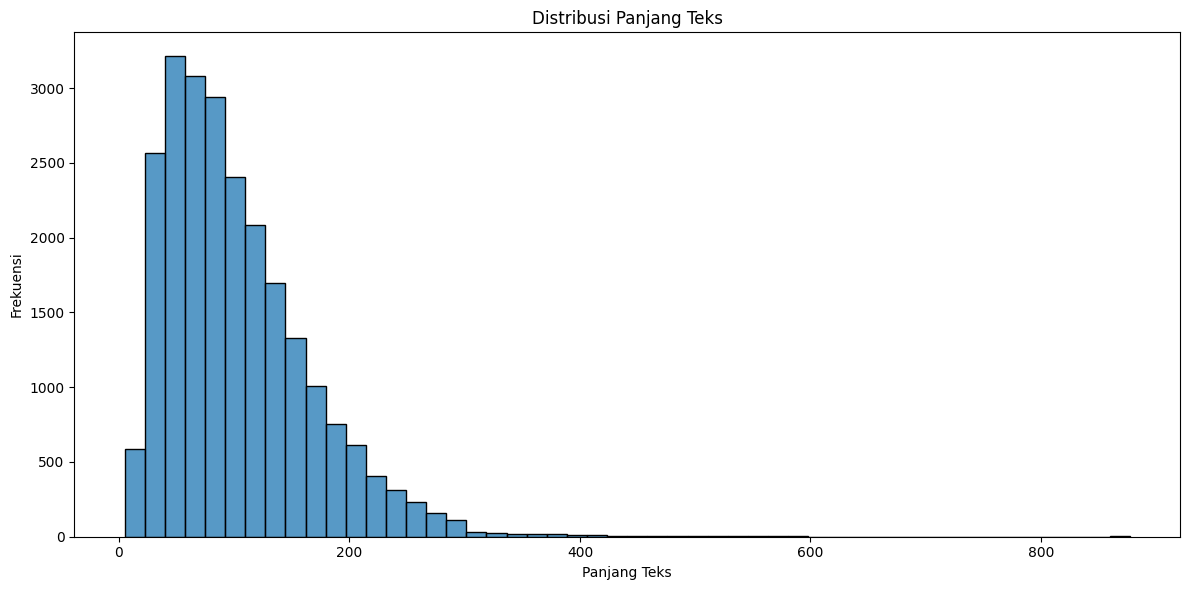


Statistik panjang teks:
count    23651.000000
mean       102.368652
std         63.748903
min          5.000000
25%         55.000000
50%         89.000000
75%        136.000000
max        877.000000
Name: text_length, dtype: float64


In [6]:
# Gabungkan semua dataset
all_data = pd.concat([isear_df, train_df], ignore_index=True)

# Tampilkan distribusi emosi sebelum preprocessing
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion', data=all_data)
plt.title('Distribusi Emosi pada Dataset Gabungan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tampilkan statistik data
print("Jumlah data per emosi:")
print(all_data['emotion'].value_counts())

# Tampilkan panjang teks
all_data['text_length'] = all_data['text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(all_data['text_length'], bins=50)
plt.title('Distribusi Panjang Teks')
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# Deskripsi statistik panjang teks
print("\nStatistik panjang teks:")
print(all_data['text_length'].describe())

## 4. Preprocessing Teks
**Tujuan**: Membersihkan dan menormalkan teks dengan menghapus URL, mention, tanda baca, angka, serta menerapkan tokenisasi, penghapusan stopwords, dan lemmatisasi.


Contoh hasil preprocessing:
                                            Original  \
0  Every time I imagine that someone I love or I ...   
1  When I had been obviously unjustly treated and...   
2  When I think about the short time that we live...   
3  At a gathering I found myself involuntarily si...   
4  When I realized that I was directing the feeli...   

                                        Preprocessed  
0  every time imagine someone love could contact ...  
1  obviously unjustly treated possibility elucida...  
2  think short time live relate period life think...  
3  gathering found involuntarily sitting next two...  
4  realized directing feeling discontent partner ...  


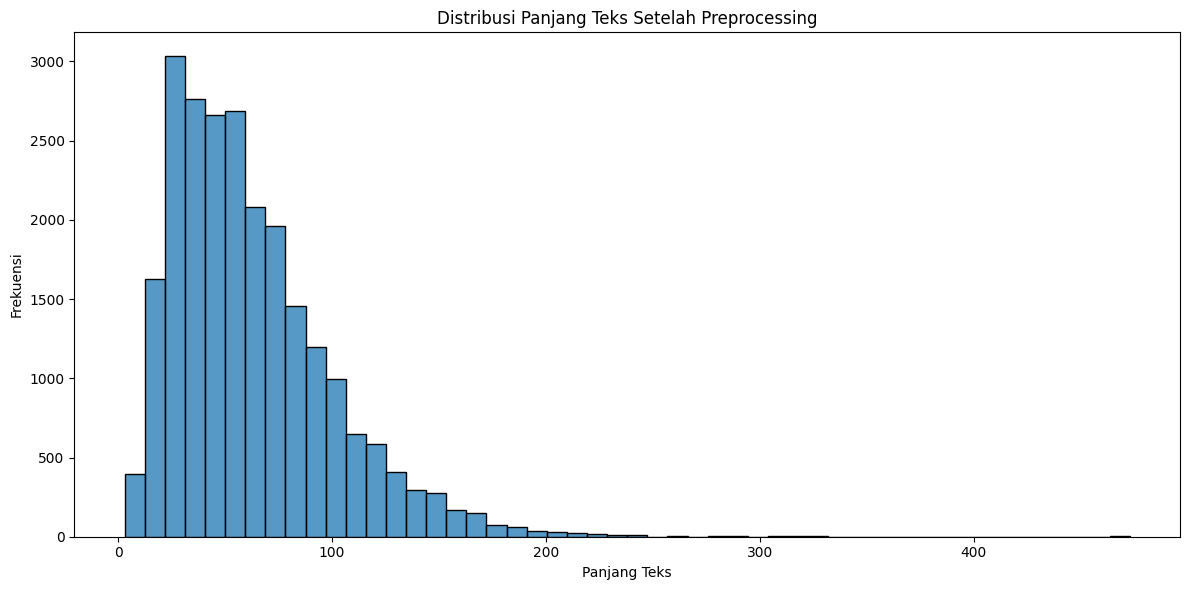


Statistik panjang teks setelah preprocessing:
count    23651.000000
mean        62.262737
std         37.529903
min          3.000000
25%         34.000000
50%         54.000000
75%         82.000000
max        473.000000
Name: processed_length, dtype: float64


In [7]:
# Fungsi untuk preprocessing teks
def preprocess_text(text):
    # Konversi ke lowercase
    text = text.lower()
    
    # Hapus karakter yang tidak perlu
    text = re.sub(r'http\S+', '', text)  # Hapus URL
    text = re.sub(r'@\w+', '', text)      # Hapus mention
    text = re.sub(r'#\w+', '', text)      # Hapus hashtag
    text = re.sub(r'\d+', '', text)       # Hapus angka
    
    # Hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenisasi
    tokens = nltk.word_tokenize(text)
    
    # Hapus stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisasi
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Gabungkan kembali
    text = ' '.join(tokens)
    
    return text

# Terapkan preprocessing pada semua dataset
all_data['processed_text'] = all_data['text'].apply(preprocess_text)

# Preprocessing untuk validation dan test dataset
val_df['processed_text'] = val_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

# Tampilkan contoh hasil preprocessing
print("Contoh hasil preprocessing:")
comparison_df = pd.DataFrame({
    'Original': all_data['text'][:5],
    'Preprocessed': all_data['processed_text'][:5]
})
print(comparison_df)

# Tampilkan distribusi panjang teks setelah preprocessing
all_data['processed_length'] = all_data['processed_text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(all_data['processed_length'], bins=50)
plt.title('Distribusi Panjang Teks Setelah Preprocessing')
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# Deskripsi statistik panjang teks setelah preprocessing
print("\nStatistik panjang teks setelah preprocessing:")
print(all_data['processed_length'].describe())

## 5. Memuat Embedding GloVe
**Tujuan**: Mengimpor embedding GloVe yang telah dilatih sebelumnya untuk representasi kata berbasis vektor numerik.


In [8]:
# Fungsi untuk memuat embeddings GloVe
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
    return embeddings_index

# Load GloVe embeddings
try:
    embeddings_index = load_glove_embeddings('dataset/glove.6B.50d.txt')
    embedding_dim = 50  # GloVe 50d
except Exception as e:
    print(f"Error loading GloVe embeddings: {e}")
    embeddings_index = {}
    embedding_dim = 50

Found 400000 word vectors.


## 6. Tokenisasi dan Padding
**Tujuan**: Mengubah teks menjadi urutan angka (token) lalu menyamakan panjangnya menggunakan padding agar dapat digunakan sebagai input ke model neural network.


In [9]:
# Tokenisasi dan padding
max_len = 100  # Panjang maksimum sequence
vocab_size = 10000  # Ukuran kosakata

# Buat tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(all_data['processed_text'])

# Konversi teks ke sequences
train_sequences = tokenizer.texts_to_sequences(all_data['processed_text'])
val_sequences = tokenizer.texts_to_sequences(val_df['processed_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['processed_text'])

# Padding sequences
X_train = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_val = pad_sequences(val_sequences, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Tampilkan informasi
print(f"Jumlah kata unik dalam vocabulary: {len(tokenizer.word_index)}")
print(f"Vocabulary size: {vocab_size}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Jumlah kata unik dalam vocabulary: 16767
Vocabulary size: 10000
X_train shape: (23651, 100)
X_val shape: (2000, 100)
X_test shape: (2000, 100)


## 7. Encoding Label
**Tujuan**: Mengonversi label emosi ke format numerik dan melakukan one-hot encoding untuk klasifikasi multi-kelas.



In [10]:
# Konversi label menjadi one-hot encoding
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(all_data['emotion'])
y_val = label_encoder.transform(val_df['emotion'])
y_test = label_encoder.transform(test_df['emotion'])

# Konversi ke one-hot encoding
from tensorflow.keras.utils import to_categorical

num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Tampilkan informasi
print(f"Label Classes: {label_encoder.classes_}")
print(f"Number of classes: {num_classes}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

Label Classes: ['anger' 'disgust' 'fear' 'guilt' 'joy' 'love' 'sadness' 'shame'
 'surprise']
Number of classes: 9
y_train shape: (23651, 9)
y_val shape: (2000, 9)
y_test shape: (2000, 9)


## 8. Membuat Matriks Embedding
**Tujuan**: Menyusun matriks embedding berdasarkan kosakata tokenizer dan vektor GloVe, serta menghitung persentase kata yang ditemukan dalam GloVe.


In [11]:
# Buat matrix embedding
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Cek persentase kata yang ditemukan dalam GloVe
found_words = 0
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        if embeddings_index.get(word) is not None:
            found_words += 1

print(f"Jumlah kata yang ditemukan dalam GloVe: {found_words}")
print(f"Persentase kata yang ditemukan: {found_words / min(len(tokenizer.word_index), vocab_size) * 100:.2f}%")

Jumlah kata yang ditemukan dalam GloVe: 9371
Persentase kata yang ditemukan: 93.71%


## 9. Membangun Model Baseline
**Tujuan**: Membuat model awal menggunakan arsitektur Bi-LSTM dengan layer embedding statis dari GloVe, kemudian menyusun jaringan LSTM dasar untuk baseline evaluasi.



In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Membangun model baseline
def build_baseline_model(vocab_size, embedding_dim, embedding_matrix, max_len, num_classes):
    """
    Membangun model Bi-LSTM baseline untuk klasifikasi emosi
    """
    model = Sequential()
    
    # Embedding Layer tanpa input_length dan tanpa +1 jika embedding_matrix sudah sesuai
    model.add(Embedding(vocab_size,  # Hapus +1
                        embedding_dim,
                        weights=[embedding_matrix],
                        trainable=False))
    
    # Spatial Dropout untuk mencegah overfitting
    model.add(SpatialDropout1D(0.2))
    
    # Bi-LSTM Layer 1
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    
    # Bi-LSTM Layer 2
    model.add(Bidirectional(LSTM(64)))
    
    # Dense Layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy',  # Sesuaikan dengan format label
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    
    return model

# Inisiasi model baseline (pastikan variabel sudah didefinisikan)
baseline_model = build_baseline_model(
    vocab_size=vocab_size,  # Gunakan nilai asli tanpa +1
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix,
    max_len=max_len,
    num_classes=num_classes
)

# Tampilkan ringkasan model
baseline_model.build(input_shape=(None, max_len))  # Bangun model dengan shape input
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 50)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 50)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       183,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 856,489 (3.27 MB)

 Trainable params: 356,489 (1.36 MB)

 Non-trainable params: 500,000 (1.91 MB)

## 10. Melatih Model 
**Tujuan**: Melatih model baseline menggunakan early stopping dan menyimpan model terbaik, lalu menguji performa pada data uji.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Membangun model baseline (dari kode sebelumnya, dengan perubahan loss function)
def build_baseline_model(vocab_size, embedding_dim, embedding_matrix, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size,
                        embedding_dim,
                        weights=[embedding_matrix],
                        trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',  # Ubah ke categorical_crossentropy
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    
    return model

# Inisiasi model baseline (pastikan variabel sudah didefinisikan)
baseline_model = build_baseline_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix,
    max_len=max_len,
    num_classes=num_classes
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', 
                                   mode='max', save_best_only=True, verbose=1)

# Melatih model
history_baseline = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluasi model pada test set
test_loss, test_acc = baseline_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.3413 - loss: 1.7920
Epoch 1: val_accuracy improved from -inf to 0.58800, saving model to best_model.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 159s 379ms/step - accuracy: 0.3414 - loss: 1.7916 - val_accuracy: 0.5880 - val_loss: 1.1604
Epoch 2/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4879 - loss: 1.4037
Epoch 2: val_accuracy improved from 0.58800 to 0.66600, saving model to best_model.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 129s 347ms/step - accuracy: 0.4880 - loss: 1.4036 - val_accuracy: 0.6660 - val_loss: 0.9186
Epoch 3/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.5580 - loss: 1.2026
Epoch 3: val_accuracy improved from 0.66600 to 0.71450, saving model to best_model.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 133s 358ms/step - accuracy: 0.5580 - loss: 1.2025 - val_accuracy: 0.7145 - val_loss: 0.7479
Epoch 4/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.6209 - loss: 1.0549
Epoch 4: val_accuracy

## 11. Visualisasi Hasil Baseline

**Purpose**: Visualizes training history (accuracy and loss) and confusion matrix for the baseline model, along with a classification report.


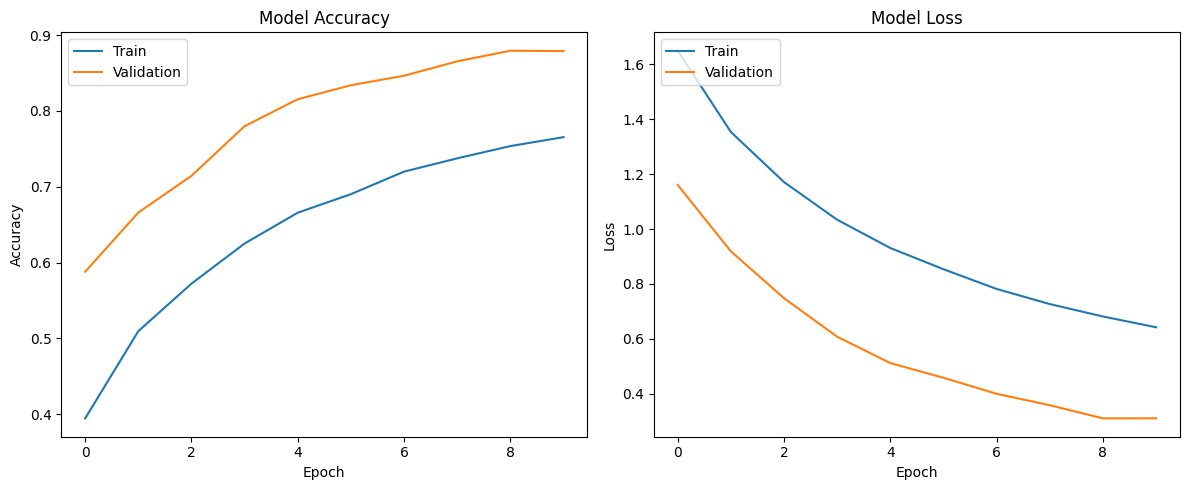

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step


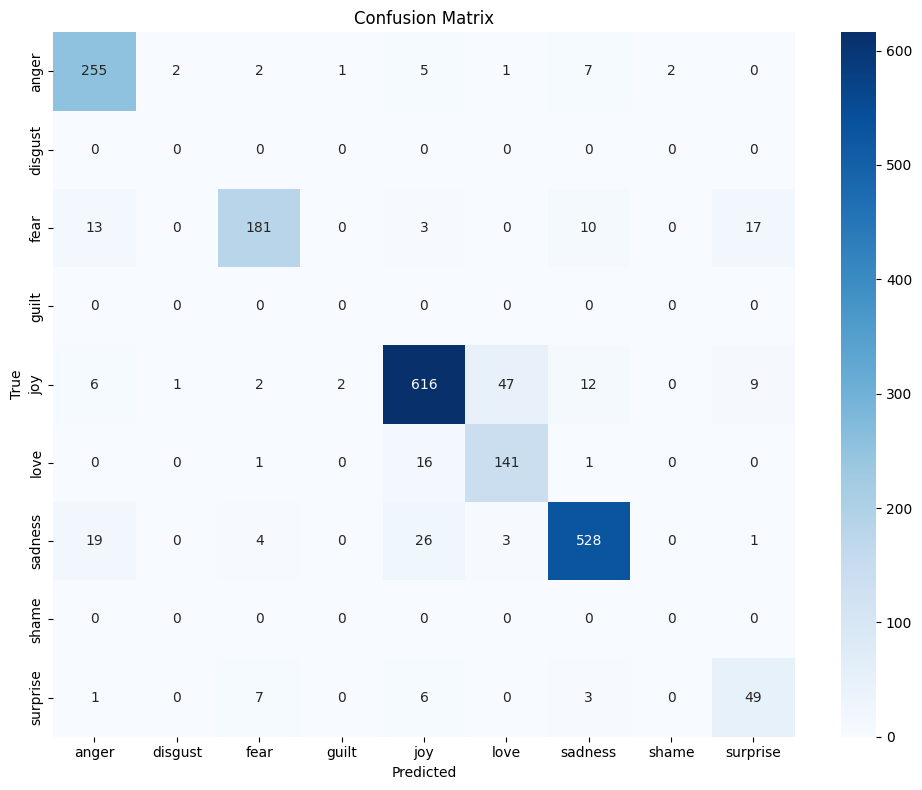

              precision    recall  f1-score   support

       anger       0.87      0.93      0.90       275
     disgust       0.00      0.00      0.00         0
        fear       0.92      0.81      0.86       224
       guilt       0.00      0.00      0.00         0
         joy       0.92      0.89      0.90       695
        love       0.73      0.89      0.80       159
     sadness       0.94      0.91      0.92       581
       shame       0.00      0.00      0.00         0
    surprise       0.64      0.74      0.69        66

    accuracy                           0.89      2000
   macro avg       0.56      0.57      0.56      2000
weighted avg       0.89      0.89      0.89      2000



c:\Users\YogaNzm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\YogaNzm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\YogaNzm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [14]:

def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot history baseline
plot_history(history_baseline)

# Plot confusion matrix
def plot_confusion_matrix(model, X, y_true):
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)
    
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Plot confusion matrix untuk baseline model
plot_confusion_matrix(baseline_model, X_test, y_test)


## 12. Tuning Model

**Purpose**: Builds a tuned Bi-LSTM model with additional layers, adjusted dropout rates, and a smaller learning rate.


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Fungsi untuk membangun model yang telah di-tuned
def build_tuned_model(vocab_size, embedding_dim, embedding_matrix, max_len, num_classes):
    model = Sequential()
    
    # Embedding Layer tanpa input_length
    model.add(Embedding(vocab_size,
                        embedding_dim,
                        weights=[embedding_matrix],
                        trainable=True))
    
    # Spatial Dropout untuk mencegah overfitting
    model.add(SpatialDropout1D(0.3))
    
    # Layer 1: Bidirectional LSTM dengan lebih banyak unit
    model.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
    
    # Layer 2: Bidirectional LSTM dengan return_sequences=True
    model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
    
    # Layer 3: Bidirectional LSTM tanpa return_sequences
    model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
    
    # Dense Layer dengan lebih banyak neuron
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile dengan learning rate yang lebih kecil
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0005),
                  metrics=['accuracy'])
    
    return model

# Inisiasi model yang di-tuned (pastikan variabel sudah didefinisikan)
tuned_model = build_tuned_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix,
    max_len=max_len,  # Hanya untuk referensi, tidak digunakan di layer Embedding
    num_classes=num_classes
)

# Tampilkan ringkasan model setelah membangun model
tuned_model.build(input_shape=(None, max_len))  # None untuk batch size dinamis
tuned_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 50)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 100, 50)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100, 512)       │       628,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 100, 256)       │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,967,145 (7.50 MB)

 Trainable params: 1,967,145 (7.50 MB)

 Non-trainable params: 0 (0.00 B)

## 13. Melatih Model yang Telah Di-tuning

**Purpose**: Trains the tuned model with updated hyperparameters and evaluates its performance on the test set.


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    'best_tuned_model.keras',  # Ubah ekstensi ke .keras
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Melatih model yang telah di-tuning
history_tuned = tuned_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,  # Batch size yang lebih kecil
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Evaluasi model pada test set
test_loss_tuned, test_acc_tuned = tuned_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy (Tuned Model): {test_acc_tuned:.4f}")

Epoch 1/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.3084 - loss: 1.8448
Epoch 1: val_accuracy improved from -inf to 0.54950, saving model to best_tuned_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 534s 695ms/step - accuracy: 0.3084 - loss: 1.8447 - val_accuracy: 0.5495 - val_loss: 1.2399
Epoch 2/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.4407 - loss: 1.5122
Epoch 2: val_accuracy improved from 0.54950 to 0.63450, saving model to best_tuned_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 532s 718ms/step - accuracy: 0.4407 - loss: 1.5121 - val_accuracy: 0.6345 - val_loss: 0.9247
Epoch 3/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.5384 - loss: 1.2760
Epoch 3: val_accuracy improved from 0.63450 to 0.77200, saving model to best_tuned_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 507s 685ms/step - accuracy: 0.5385 - loss: 1.2759 - val_accuracy: 0.7720 - val_loss: 0.6051
Epoch 4/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.6127 - loss: 1.0704
Epo

## 14. Visualisasi Hasil Model yang Di-tuning

**Purpose**: Visualizes training history and confusion matrix for the tuned model.


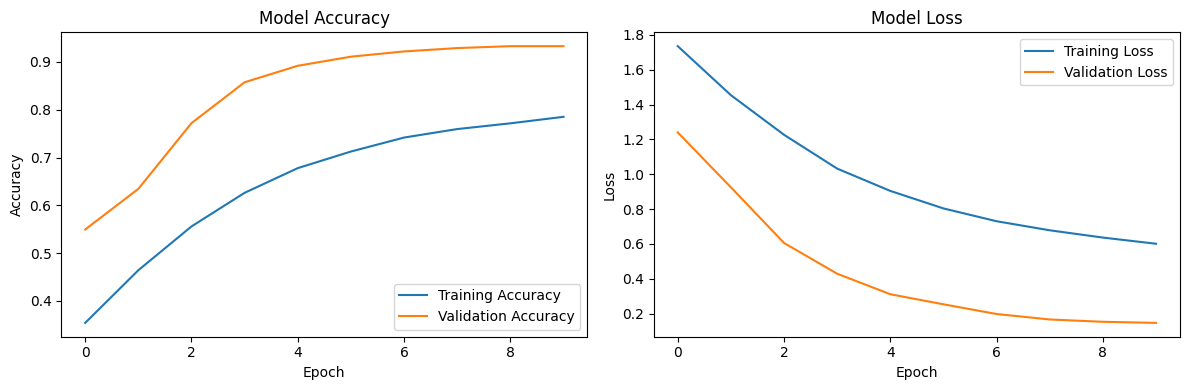

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step


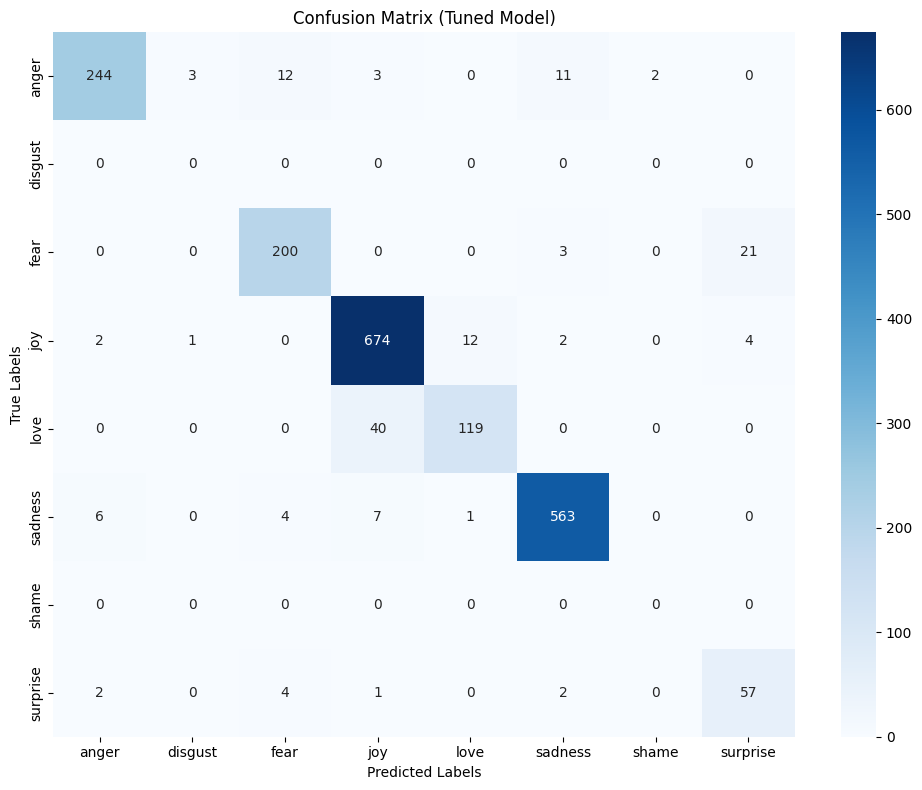


Classification Report (Tuned Model):
              precision    recall  f1-score   support

       anger       0.96      0.89      0.92       275
     disgust       0.00      0.00      0.00         0
        fear       0.91      0.89      0.90       224
         joy       0.93      0.97      0.95       695
        love       0.90      0.75      0.82       159
     sadness       0.97      0.97      0.97       581
       shame       0.00      0.00      0.00         0
    surprise       0.70      0.86      0.77        66

    accuracy                           0.93      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.93      0.93      0.93      2000



c:\Users\YogaNzm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\YogaNzm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\YogaNzm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Fungsi untuk plot history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Fungsi untuk plot confusion matrix
def plot_confusion_matrix(model, X_test, y_test):
    # Prediksi
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
    
    # Hitung confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    
    # Dapatkan kelas unik dari data aktual dan prediksi
    unique_classes = np.unique(np.concatenate([y_test_classes, y_pred_classes]))
    target_names = [label_encoder.classes_[i] for i in unique_classes]
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Tuned Model)')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report (Tuned Model):")
    print(classification_report(y_test_classes, y_pred_classes, target_names=target_names))

# Plot history untuk model yang di-tuning
plot_history(history_tuned)

# Plot confusion matrix untuk model yang di-tuning
plot_confusion_matrix(tuned_model, X_test, y_test)

## 15. Uji Model dengan Teks Baru

**Purpose**: Defines a function to predict emotions for new text inputs and visualizes the prediction probabilities for a sample text.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
                                                Text Predicted Emotion  \
0  I am so happy to see you again after all these...               joy   
1  The news of the accident made me very sad and ...           sadness   
2  I was terrified when I heard the loud noise in...              fear   
3  His behavior made me really angry and frustrated.             anger   
4  I feel disgusted by the way they treated the h...             anger   

   Confidence  
0    0.987957  
1    0.983465  
2    0.990176  
3    0.827704  
4    0.611844  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


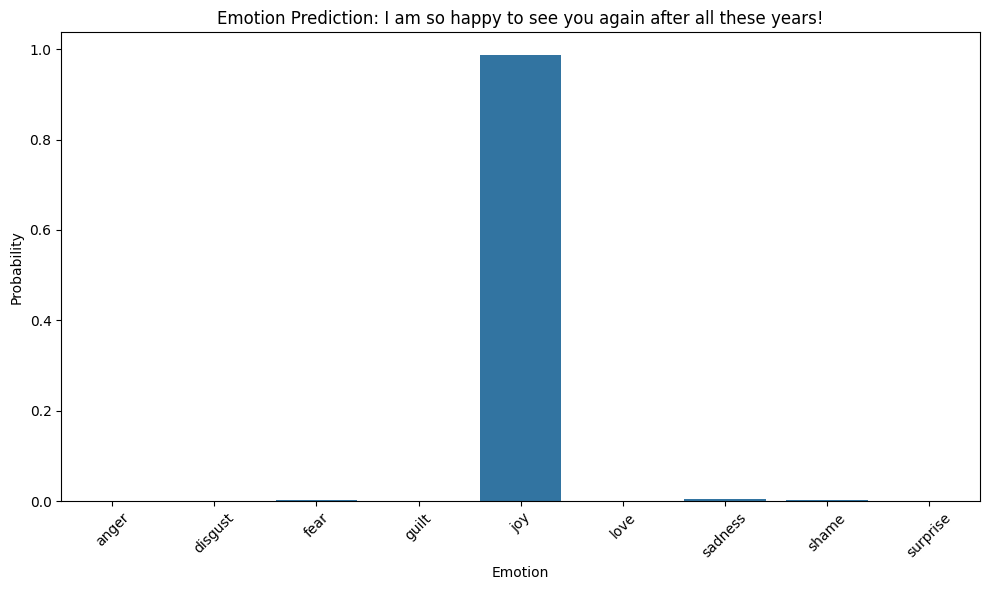

In [19]:
def predict_emotion(text, model):
    # Preprocessing
    processed_text = preprocess_text(text)
    
    # Tokenisasi dan padding
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    
    # Prediksi
    prediction = model.predict(padded_sequence)[0]
    predicted_class = np.argmax(prediction)
    emotion = label_encoder.classes_[predicted_class]
    confidence = prediction[predicted_class]
    
    return emotion, confidence, prediction

# Contoh teks baru
new_texts = [
    "I am so happy to see you again after all these years!",
    "The news of the accident made me very sad and worried.",
    "I was terrified when I heard the loud noise in the middle of the night.",
    "His behavior made me really angry and frustrated.",
    "I feel disgusted by the way they treated the homeless person."
]

# Prediksi dengan model yang di-tuning
results = []
for text in new_texts:
    emotion, confidence, prediction = predict_emotion(text, tuned_model)
    results.append({
        'Text': text,
        'Predicted Emotion': emotion,
        'Confidence': confidence
    })

# Tampilkan hasil
results_df = pd.DataFrame(results)
print(results_df)

# Visualisasi prediksi untuk teks pertama
plt.figure(figsize=(10, 6))
emotion_probs = predict_emotion(new_texts[0], tuned_model)[2]
sns.barplot(x=label_encoder.classes_, y=emotion_probs)
plt.title(f'Emotion Prediction: {new_texts[0]}')
plt.xlabel('Emotion')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🔍 Kesimpulan Performa Model Prediksi Emosi

Model deep learning yang dikembangkan untuk klasifikasi emosi menunjukkan performa yang sangat baik dengan **akurasi keseluruhan sebesar 93%** pada data uji berjumlah 2000 sampel.

#### 📊 Performa per Kelas Emosi:
- `joy`: F1-Score **0.95** (precision: 0.93, recall: 0.97)
- `sadness`: F1-Score **0.97** (precision: 0.97, recall: 0.97)
- `anger`: F1-Score **0.92** (precision: 0.96, recall: 0.89)
- `fear`: F1-Score **0.90** (precision: 0.91, recall: 0.89)
- `love`: F1-Score **0.82** (precision: 0.90, recall: 0.75)
- `surprise`: F1-Score **0.77** (precision: 0.70, recall: 0.86)
- `disgust` dan `shame`: F1-Score **0.0** (support = 0) → Tidak tersedia di data uji

#### 📌 Contoh Hasil Prediksi:
- `"I am so happy to see you again"` → `joy` (confidence: 0.98)
- `"The news made me very sad"` → `sadness` (confidence: 0.98)
- `"I was terrified at night"` → `fear` (confidence: 0.99)
- `"He made me angry"` → `anger` (confidence: 0.82)
- `"I feel disgusted"` → Prediksi `anger` (confidence: 0.61) → indikasi ambiguitas semantik

#### 📈 Grafik Akurasi & Loss:
- Akurasi training & validation naik stabil hingga ~0.90
- Loss turun konsisten hingga 0.4–0.6 pada epoch ke-8
- Indikasi **konvergensi baik & overfitting minimal**

#### 🧩 Confusion Matrix:
- `joy`: 674 dari 695 benar
- `sadness`: 563 dari 581
- `anger`: 244 dari 275
- `fear`: 200 dari 224
- Beberapa misklasifikasi: `love` → `joy`, `surprise` → `fear`
- `disgust` & `shame` → tidak terprediksi (support nol)

#### ✅ Kesimpulan Umum:
Model ini sangat efektif untuk emosi dominan (joy, sadness, anger, fear) dengan akurasi tinggi dan prediksi yang konsisten. Performa pada kelas minoritas perlu ditingkatkan dengan menyeimbangkan distribusi data pelatihan.
